In [1]:
import numpy as np
import math
import random
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import copy

# --- Framework-agnostic Data Generation Code ---
class StockOracle:
    """
    A class to simulate a stock's price using various stochastic processes.
    This version is simplified for generating clean datasets for the ML model.
    """
    def __init__(self, periods=252, x0=100, kappa=0.5, theta=100, sigma=0.5,
                 pump_start_percent=0.4, pump_end_percent=0.6, dump_end_percent=0.7,
                 post_dump_drift_strength=0.1, simulation_type="pump_and_dump", trend_drift=0.5):
        self.periods = periods
        self.x0 = x0
        self.kappa = kappa
        self.theta = theta
        self.sigma = sigma
        self.pump_start_percent = pump_start_percent
        self.pump_end_percent = pump_end_percent
        self.dump_end_percent = dump_end_percent
        self.post_dump_drift_strength = post_dump_drift_strength
        self.simulation_type = simulation_type
        self.trend_drift = trend_drift

        if self.simulation_type == "pump_and_dump":
            self.price_history = self._simulate_pump_dump_data()
        elif self.simulation_type == "mean_reverting":
            self.price_history = self._simulate_mean_reverting_data()
        elif self.simulation_type == "trend":
            self.price_history = self._simulate_trend_data()
        else:
            raise ValueError("Invalid simulation_type provided.")

    def _simulate_pump_dump_data(self):
        s = [self.x0]
        dt = 1.0 / self.periods
        pump_start_idx = int(self.periods * self.pump_start_percent)
        pump_end_idx = int(self.periods * self.pump_end_percent)
        dump_end_idx = int(self.periods * self.dump_end_percent)

        for t in range(1, self.periods):
            s_t_minus_1 = s[t - 1]
            drift = self.kappa * (self.theta - s_t_minus_1) * dt
            volatility = s_t_minus_1 * self.sigma * math.sqrt(dt) * random.gauss(0, 1)
            additional_drift = 0

            if pump_start_idx <= t < pump_end_idx:
                additional_drift = 2.0 * dt * self.x0
            elif pump_end_idx <= t < dump_end_idx:
                additional_drift = -5.0 * dt * self.x0
            elif t >= dump_end_idx:
                additional_drift = -self.post_dump_drift_strength * (s_t_minus_1 - self.x0) * dt

            s_t = (s_t_minus_1 + drift + volatility + additional_drift)
            s.append(max(0, s_t))
        return np.array(s)

    def _simulate_mean_reverting_data(self):
        s = [self.x0]
        dt = 1.0 / self.periods
        for t in range(1, self.periods):
            s_t_minus_1 = s[t - 1]
            drift = self.kappa * (self.theta - s_t_minus_1) * dt
            volatility = s_t_minus_1 * self.sigma * math.sqrt(dt) * random.gauss(0, 1)
            s_t = (s_t_minus_1 + drift + volatility)
            s.append(max(0, s_t))
        return np.array(s)

    def _simulate_trend_data(self):
        s = [self.x0]
        dt = 1.0 / self.periods
        for t in range(1, self.periods):
            s_t_minus_1 = s[t - 1]
            drift = self.trend_drift * dt * self.x0
            volatility = s_t_minus_1 * self.sigma * math.sqrt(dt) * random.gauss(0, 1)
            s_t = (s_t_minus_1 + drift + volatility)
            s.append(max(0, s_t))
        return np.array(s)

def generate_dataset(num_samples, periods):
    """
    Generates a synthetic dataset of stock price time series.
    Returns:
        X (np.array): shape (num_samples, periods)
        y (np.array): shape (num_samples, 1)
    """
    X = []
    y = []

    # Number of samples for each class
    num_pump_dump = int(num_samples * 0.5)
    num_normal = num_samples - num_pump_dump
    num_mean_reverting = num_normal // 2
    num_trend = num_normal - num_mean_reverting

    # Generate pump-and-dump data
    for _ in range(num_pump_dump):
        oracle = StockOracle(periods=periods, x0=100 + random.uniform(-20, 20),
                             sigma=random.uniform(0.1, 0.7),
                             pump_start_percent=random.uniform(0.1, 0.4),
                             pump_end_percent=random.uniform(0.5, 0.65),
                             dump_end_percent=random.uniform(0.65, 0.75))
        X.append(oracle._simulate_pump_dump_data())
        y.append(1)

    # Generate normal mean-reverting data
    for _ in range(num_mean_reverting):
        oracle = StockOracle(periods=periods, x0=100 + random.uniform(-20, 20),
                             sigma=random.uniform(0.1, 0.5),
                             theta=100 + random.uniform(-20, 20))
        X.append(oracle._simulate_mean_reverting_data())
        y.append(0)

    # Generate normal trending data
    for _ in range(num_trend):
        oracle = StockOracle(periods=periods, x0=100 + random.uniform(-20, 20),
                             sigma=random.uniform(0.1, 0.5),
                             trend_drift=random.uniform(-0.005, 0.005))
        X.append(oracle._simulate_trend_data())
        y.append(0)

    X = np.array(X)
    y = np.array(y).reshape(-1, 1)

    # Shuffle the data
    indices = np.arange(num_samples)
    np.random.shuffle(indices)

    return X[indices], y[indices]

def normalize_data(data):
    """
    Normalizes a dataset of multiple time series using Min-Max Scaling on each series.
    """
    normalized_data = np.zeros_like(data, dtype=np.float32)
    for i in range(data.shape[0]):
        series = data[i, :]
        scaler = MinMaxScaler(feature_range=(0, 1))
        # Reshape for the scaler: (n_samples, n_features)
        normalized_series = scaler.fit_transform(series.reshape(-1, 1)).flatten()
        normalized_data[i, :] = normalized_series
    return normalized_data

def generate_windowed_dataset(X, y, window_size, stride):
    """
    Generates a windowed dataset from the full time series.
    Args:
        X (np.array): Full time series data, shape (num_samples, periods)
        y (np.array): Labels for the full time series, shape (num_samples, 1)
        window_size (int): The number of time steps in each window.
        stride (int): The number of steps the window moves forward each time.
    Returns:
        X_windowed (np.array): The windowed data, shape (num_windows, window_size, 1)
        y_windowed (np.array): Labels for each window, shape (num_windows, 1)
    """
    X_windowed = []
    y_windowed = []

    # Ensure y is a 2D array for consistent indexing
    y = y.reshape(-1, 1)

    for i in range(X.shape[0]):
        series = X[i, :]
        label = y[i, 0]

        # Determine the pump-and-dump period for labeling
        # This is a key step to correctly label windows
        if label == 1:
            pump_start_idx = np.where(series > 1.2 * series[0])[0][0] if np.any(series > 1.2 * series[0]) else len(series)
            dump_end_idx = np.argmax(series) + np.where(series[np.argmax(series):] < 0.7 * series[np.argmax(series)])[0][0] if np.any(series[np.argmax(series):] < 0.7 * series[np.argmax(series)]) else len(series)
        else:
            pump_start_idx, dump_end_idx = -1, -1 # No pump-and-dump for normal series

        # Create windows for this series
        for j in range(0, series.shape[0] - window_size + 1, stride):
            window = series[j:j + window_size]
            X_windowed.append(window)

            # Assign label based on whether the window contains the pump-and-dump event
            window_end_idx = j + window_size
            if label == 1 and (
                (j <= pump_start_idx < window_end_idx) or
                (j <= dump_end_idx < window_end_idx) or
                (pump_start_idx >= j and dump_end_idx <= window_end_idx)
            ):
                y_windowed.append(1)
            else:
                y_windowed.append(0)

    X_windowed = np.array(X_windowed)
    y_windowed = np.array(y_windowed).reshape(-1, 1)

    return X_windowed, y_windowed

# --- PyTorch Specific Code ---

class TimeseriesDataset(Dataset):
    """
    A custom PyTorch Dataset for time series data.
    """
    def __init__(self, sequences, labels):
        self.sequences = torch.tensor(sequences, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

# --- Model Definition ---
class PumpDumpClassifier(nn.Module):
    """
    A PyTorch-based LSTM model to classify time-series data.
    """
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, dropout_prob=0.2):
        super(PumpDumpClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_hidden_state = lstm_out[:, -1, :]
        out = self.fc(last_hidden_state)
        out = torch.sigmoid(out)
        return out


In [3]:
from sklearn.preprocessing import MinMaxScaler

# --- Main Execution ---
if __name__ == "__main__":
    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Hyperparameters
    NUM_SAMPLES = 30_000
    PERIODS = 252 # Number of trading days in a year
    WINDOW_SIZE = 120 # Number of days in each window
    STRIDE = 15 # The step size for the sliding window
    EPOCHS = 50
    BATCH_SIZE = 32
    LEARNING_RATE = 0.001

    INPUT_SIZE = 1
    HIDDEN_SIZE = 64
    NUM_LAYERS = 2
    DROPOUT_RATE = 0.2

    # Early stopping parameters
    PATIENCE = 5
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    print("Generating synthetic data...")
    X_full, y_full = generate_dataset(num_samples=NUM_SAMPLES, periods=PERIODS)
    X_full = normalize_data(X_full)
    print("Synthetic data normalized.")

    print("Creating windowed dataset...")
    X_windowed, y_windowed = generate_windowed_dataset(X_full, y_full, WINDOW_SIZE, STRIDE)
    print(f"Original series: {NUM_SAMPLES}, Windowed samples: {X_windowed.shape[0]}")
    print(f"Pump-and-Dump windows: {np.sum(y_windowed)} | Normal windows: {len(y_windowed) - np.sum(y_windowed)}")

    # Split the windowed data into training, validation, and test sets
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X_windowed, y_windowed, test_size=0.2, random_state=42, stratify=y_windowed
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=0.1, random_state=42, stratify=y_train_val
    )

    # Create PyTorch datasets and dataloaders
    train_dataset = TimeseriesDataset(X_train.reshape(-1, WINDOW_SIZE, INPUT_SIZE), y_train)
    val_dataset = TimeseriesDataset(X_val.reshape(-1, WINDOW_SIZE, INPUT_SIZE), y_val)
    test_dataset = TimeseriesDataset(X_test.reshape(-1, WINDOW_SIZE, INPUT_SIZE), y_test)

    train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    print("\nTraining PyTorch LSTM model with early stopping...")
    model = PumpDumpClassifier(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, DROPOUT_RATE).to(device)

    # Loss and optimizer
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # Training loop
    for epoch in range(EPOCHS):
        model.train()
        for i, (sequences, labels) in enumerate(train_loader):
            sequences = sequences.to(device)
            labels = labels.to(device)
            outputs = model(sequences)
            loss = criterion(outputs, labels) # Fixed here
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Validation step
        model.eval()
        with torch.no_grad():
            val_loss = 0
            for sequences, labels in val_loader:
                sequences = sequences.to(device)
                labels = labels.to(device)
                outputs = model(sequences)
                val_loss += criterion(outputs, labels).item() # Fixed here
            val_loss /= len(val_loader)
            print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}, Validation Loss: {val_loss:.4f}')

        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = copy.deepcopy(model.state_dict())
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print(f"Early stopping at epoch {epoch+1}. Restoring best model state.")
                model.load_state_dict(best_model_state)
                break

    print("\nEvaluating model performance...")
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for sequences, labels in test_loader:
            sequences = sequences.to(device)
            outputs = model(sequences)
            predicted = outputs.round()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=["Normal", "Pump-and-Dump"]))

    # Save the trained model
    torch.save(model.state_dict(), 'best_model_windowed.pth')
    print("\nModel saved to best_model_windowed.pth")

Using device: cuda
Generating synthetic data...
Synthetic data normalized.
Creating windowed dataset...
Original series: 30000, Windowed samples: 270000
Pump-and-Dump windows: 112890 | Normal windows: 157110

Training PyTorch LSTM model with early stopping...
Epoch [1/50], Loss: 0.5950, Validation Loss: 0.6418
Epoch [2/50], Loss: 0.3691, Validation Loss: 0.3935
Epoch [3/50], Loss: 0.3597, Validation Loss: 0.3797
Epoch [4/50], Loss: 0.3078, Validation Loss: 0.3328
Epoch [5/50], Loss: 0.2674, Validation Loss: 0.3207
Epoch [6/50], Loss: 0.3385, Validation Loss: 0.3205
Epoch [7/50], Loss: 0.2809, Validation Loss: 0.3176
Epoch [8/50], Loss: 0.2799, Validation Loss: 0.3160
Epoch [9/50], Loss: 0.2851, Validation Loss: 0.3067
Epoch [10/50], Loss: 0.3129, Validation Loss: 0.3026
Epoch [11/50], Loss: 0.2641, Validation Loss: 0.2977
Epoch [12/50], Loss: 0.2645, Validation Loss: 0.2988
Epoch [13/50], Loss: 0.3713, Validation Loss: 0.2957
Epoch [14/50], Loss: 0.1596, Validation Loss: 0.3055
Epoch [

In [5]:
import yfinance as yf
import pandas as pd
import warnings
from datetime import date

# Suppress DeprecationWarnings from jupyter_client
warnings.filterwarnings(
    "ignore",
    category=DeprecationWarning,
    module="jupyter_client",
    message="datetime.datetime.utcnow() is deprecated"
)

def get_bist_all_tickers(filepath):
    """
    Fetches the list of tickers for all Borsa Istanbul stocks from a CSV file.

    Args:
        filepath (str): The path to the CSV file containing the ticker list.

    Returns:
        list: A list of ticker symbols.
    """
    try:
        tickers_df = pd.read_csv(filepath)
        if "ticker" not in tickers_df.columns:
            print(f"Error: The CSV file '{filepath}' must contain a 'ticker' column.")
            return []

        tickers_df["ticker"] = tickers_df["ticker"] + ".IS"
        tickers = tickers_df["ticker"].dropna().tolist()
        return tickers
    except FileNotFoundError:
        print(f"Error: The file '{filepath}' was not found.")
        return []

def download_bist_data(start_date, end_date, ticker_list):
    """
    Downloads adjusted close prices for a list of Borsa Istanbul stocks.

    Args:
        start_date (str): The start date for the data (YYYY-MM-DD).
        end_date (str): The end date for the data (YYYY-MM-DD).
        ticker_list (list): A list of ticker symbols to download.

    Returns:
        pandas.DataFrame: A DataFrame with adjusted close prices for each stock.
    """
    if not ticker_list:
        return pd.DataFrame()

    print(f"Downloading data for {len(ticker_list)} Borsa Istanbul stocks...")

    # Download data for all tickers in a single request.
    data = yf.download(
        tickers=ticker_list,
        start=start_date,
        end=end_date,
        group_by='ticker',
        auto_adjust=True,  # Automatically adjusts prices for splits and dividends
        progress=True     # Show progress bar
    )

    # Extract only the 'Close' prices from the MultiIndex DataFrame.
    close_prices = data.loc[:, (slice(None), 'Close')]

    # Clean up column names by dropping the 'Close' level.
    close_prices.columns = close_prices.columns.droplevel(1)

    # Remove any stocks that have missing data due to delisting or other issues.
    close_prices.dropna(axis=1, how='all', inplace=True)

    return close_prices

# Define the date range for 2024
start_date = "2024-01-01"
end_date = "2024-12-31"

# Specify the path to your tickers CSV file
tickers_csv_file = "bist.csv"

# Get the list of tickers from the CSV file
bist_tickers = get_bist_all_tickers(tickers_csv_file)

if bist_tickers:
    # Download the data
    bist_prices = download_bist_data(start_date, end_date, bist_tickers)

    if not bist_prices.empty:
        # Save the data to a CSV file.
        output_filename = "bist_2024_prices.csv"
        bist_prices.to_csv(output_filename)
        print(f"\nSuccessfully downloaded data for {bist_prices.shape[1]} stocks.")
        print(f"Data saved to '{output_filename}'")
        print("\nFirst 5 rows of the downloaded data:")
        print(bist_prices.head())
        print("\nLast 5 rows of the downloaded data:")
        print(bist_prices.tail())
    else:
        print("Failed to download any stock data. Please check ticker list and dates.")
else:
    print("No tickers found. Please create a CSV file named 'bist_tickers.csv' with a 'ticker' column.")


[*********************100%***********************]  585 of 585 completed
ERROR:yfinance:
16 Failed downloads:
ERROR:yfinance:['MOPAS.IS', 'ARMGD.IS', 'BALSU.IS', 'SERNT.IS', 'VSNMD.IS', 'AKFIS.IS', 'EGEGY.IS', 'BIGEN.IS', 'BESLR.IS', 'A1YEN.IS', 'KLYPV.IS', 'ENDAE.IS', 'BULGS.IS', 'RUZYE.IS', 'GLRMK.IS', 'DSTKF.IS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2024-01-01 -> 2024-12-31) (Yahoo error = "Data doesn\'t exist for startDate = 1704056400, endDate = 1735592400")')
/tmp/ipython-input-1151832409.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  close_prices.dropna(axis=1, how='all', inplace=True)



Successfully downloaded data for 569 stocks.
Data saved to 'bist_2024_prices.csv'

First 5 rows of the downloaded data:
Ticker       ATSYH.IS  IHGZT.IS  YAYLA.IS   AGESA.IS  DESA.IS   KGYO.IS  \
Date                                                                      
2024-01-02  46.959999      1.27      6.72  58.591167    9.040  0.333545   
2024-01-03  46.000000      1.20      6.50  54.084160    9.095  0.333545   
2024-01-04  46.000000      1.22      6.56  52.501907    9.380  0.333545   
2024-01-05  47.599998      1.25      6.54  51.351181    9.700  0.333545   
2024-01-08  46.880001      1.25      6.54  51.447075    9.950  0.333545   

Ticker      IMASM.IS   VKING.IS   VANGD.IS  VAKBN.IS  ...   ZEDUR.IS  \
Date                                                  ...              
2024-01-02    3.1825  26.940001  16.639999     13.06  ...  11.158798   
2024-01-03    2.9750  29.620001  16.879999     13.01  ...  10.150214   
2024-01-04    3.0200  31.400000  16.580000     13.93  ...  10.586

In [6]:
print(bist_prices.shape)


(249, 569)


In [7]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import warnings
from sklearn.preprocessing import MinMaxScaler
import os

# Suppress DeprecationWarnings from jupyter_client
warnings.filterwarnings(
    "ignore",
    category=DeprecationWarning,
    module="jupyter_client",
    message="datetime.datetime.utcnow() is deprecated"
)

# --- Data Preprocessing and Padding ---
def pad_series_to_length(series, target_length):
    """
    Pads a pandas Series to a target length by repeating the last value.
    """
    current_length = len(series)
    if current_length >= target_length:
        return series

    num_to_pad = target_length - current_length
    last_value = series.iloc[-1]
    padded_values = [last_value] * num_to_pad

    padded_series = pd.concat([series, pd.Series(padded_values, index=range(current_length, target_length))])
    return padded_series.reset_index(drop=True)

def normalize_series(series):
    """
    Normalizes a single pandas Series using Min-Max Scaling.
    """
    scaler = MinMaxScaler(feature_range=(0, 1))
    normalized_series = scaler.fit_transform(series.values.reshape(-1, 1)).flatten()
    return normalized_series

def create_sliding_windows(series, window_size, stride):
    """
    Creates overlapping or non-overlapping windows from a time series.
    Returns:
        np.array: A 2D array of windows.
    """
    windows = []
    for i in range(0, len(series) - window_size + 1, stride):
        windows.append(series[i : i + window_size])
    return np.array(windows)

# --- Main Execution ---
if __name__ == "__main__":
    # Define constants
    BIST_DATA_FILE = "bist_2024_prices.csv"
    MODEL_FILE = "best_model_windowed.pth"
    TARGET_LENGTH = 252

    # Windowing parameters from your training script
    WINDOW_SIZE = 120
    STRIDE = 15

    INPUT_SIZE = 1
    HIDDEN_SIZE = 64
    NUM_LAYERS = 2
    DROPOUT_RATE = 0.2

    try:
        # Load the downloaded BIST stock data
        if not os.path.exists(BIST_DATA_FILE):
            raise FileNotFoundError(f"Error: The file '{BIST_DATA_FILE}' was not found. Please run the data download script first.")
        bist_prices = pd.read_csv(BIST_DATA_FILE, index_col=0, parse_dates=True)
        print(f"Successfully loaded data from '{BIST_DATA_FILE}'.")

        # Load the trained PyTorch model
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = PumpDumpClassifier(input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS, dropout_prob=DROPOUT_RATE).to(device)
        model.load_state_dict(torch.load(MODEL_FILE, map_location=device))
        model.eval()
        print(f"Successfully loaded trained model from '{MODEL_FILE}'.")
        print(f"Using device: {device}")

    except FileNotFoundError as e:
        print(e)
        exit()

    # Create a DataFrame to store the results
    results = pd.DataFrame(columns=['Ticker', 'Total Windows', 'Pump-and-Dump Flags'])

    # Loop through each stock to test the model
    print("\nAnalyzing BIST stocks...")
    for ticker in bist_prices.columns:
        stock_series = bist_prices[ticker].dropna()

        # Check if the series is long enough to create a single window
        if len(stock_series) < WINDOW_SIZE:
            print(f"  - Skipping {ticker}: Not enough data for a single window ({len(stock_series)} < {WINDOW_SIZE}).")
            continue

        # Create sliding windows
        windows = create_sliding_windows(stock_series, WINDOW_SIZE, STRIDE)

        # Normalize each window individually
        normalized_windows = np.array([normalize_series(pd.Series(w)) for w in windows])

        # Reshape for the LSTM model: (num_windows, sequence_length, input_size)
        x_tensor = torch.tensor(normalized_windows, dtype=torch.float32).unsqueeze(-1).to(device)

        # Make prediction on all windows for this stock
        with torch.no_grad():
            prediction_probs = model(x_tensor).cpu().numpy().flatten()

        # Count the number of windows flagged as "Pump-and-Dump" (prob > 0.5)
        pump_dump_count = np.sum(prediction_probs > 0.5)
        total_windows = len(windows)

        # Store the results
        new_row = pd.DataFrame([{
            'Ticker': ticker,
            'Total Windows': total_windows,
            'Pump-and-Dump Flags': pump_dump_count
        }])
        results = pd.concat([results, new_row], ignore_index=True)
        #print(f"  - {ticker}: Total Windows={total_windows}, Flagged={pump_dump_count}")

    print("\n" + "="*50)
    print("ANALYSIS SUMMARY")
    print("="*50)

    # Sort results by the number of flags in descending order
    results = results.sort_values(by='Pump-and-Dump Flags', ascending=False).reset_index(drop=True)

    # Filter for stocks with at least one pump-and-dump flag
    pump_dump_results = results[results['Pump-and-Dump Flags'] > 0]

    if not pump_dump_results.empty:
        print(pump_dump_results.to_string(index=False))
    else:
        print("No stocks were classified as a 'Pump-and-Dump' event based on the 2024 data and the current model.")

    print(f"Length of pump-and-dump dataframe: {len(pump_dump_results)}")
    print("\nAnalysis complete. The 'Pump-and-Dump Flags' column indicates the number of times a 180-day period for a stock was classified as a pump-and-dump event.")


Successfully loaded data from 'bist_2024_prices.csv'.
Successfully loaded trained model from 'best_model_windowed.pth'.
Using device: cuda

Analyzing BIST stocks...
  - Skipping TCKRC.IS: Not enough data for a single window (91 < 120).
  - Skipping AHSGY.IS: Not enough data for a single window (86 < 120).
  - Skipping DCTTR.IS: Not enough data for a single window (106 < 120).
  - Skipping GUNDG.IS: Not enough data for a single window (90 < 120).
  - Skipping LYDYE.IS: Not enough data for a single window (70 < 120).
  - Skipping CEMZY.IS: Not enough data for a single window (80 < 120).
  - Skipping OZATD.IS: Not enough data for a single window (82 < 120).
  - Skipping BAHKM.IS: Not enough data for a single window (97 < 120).
  - Skipping BINBN.IS: Not enough data for a single window (58 < 120).
  - Skipping INTEK.IS: Not enough data for a single window (109 < 120).
  - Skipping SMRVA.IS: Not enough data for a single window (9 < 120).
  - Skipping DURKN.IS: Not enough data for a single w

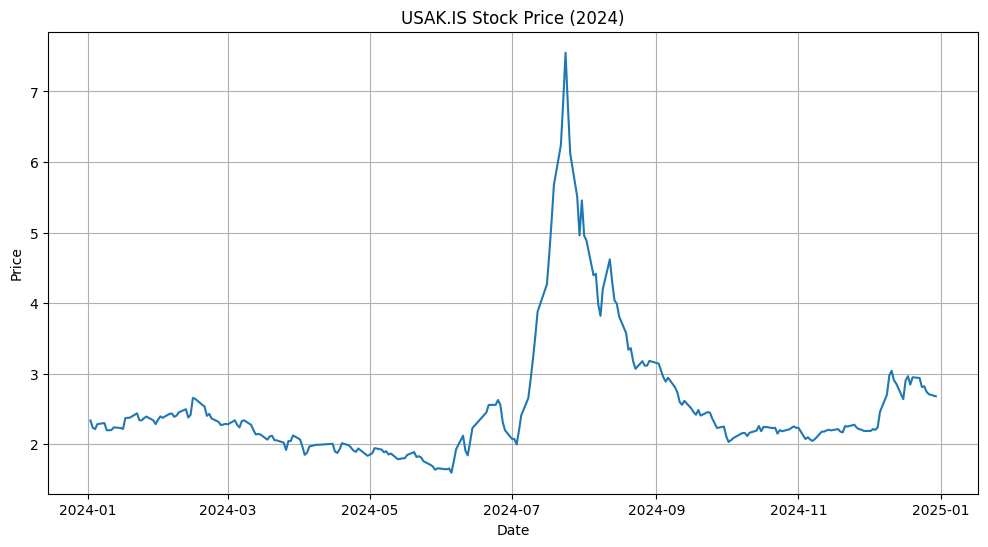

In [9]:
import matplotlib.pyplot as plt

# Select a ticker to plot (e.g., 'PEKGY.IS' as it had the most flags)
ticker_to_plot = 'USAK.IS'

if ticker_to_plot in bist_prices.columns:
    stock_series_to_plot = bist_prices[ticker_to_plot].dropna()

    plt.figure(figsize=(12, 6))
    plt.plot(stock_series_to_plot.index, stock_series_to_plot.values)
    plt.title(f'{ticker_to_plot} Stock Price (2024)')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.grid(True)
    plt.show()
else:
    print(f"Ticker '{ticker_to_plot}' not found in the downloaded data.")